In [40]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt


In [41]:
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def extract_values_by_bin(data, key, num_bins):
    bin_values = [[] for _ in range(num_bins)]
    runtime = []
    for filename, phen_data in data.items():
        for bin_data in phen_data[key]:
            bin_index = bin_data['index' if key == 'sigma' else 'bin']
            if bin_index < num_bins:
                bin_values[bin_index].append(bin_data[key])
        runtime.append(phen_data['runtime'])
    return bin_values, runtime

def process_py_rhe_data(folder_path, num_files, num_bins):
    py_rhe_sigma = [[] for _ in range(num_bins)]
    py_rhe_h2 = [[] for _ in range(num_bins)]
    py_rhe_enrichment = [[] for _ in range(num_bins)]
    py_rhe_runtime = []

    for i in range(num_files):
        file_path = os.path.join(folder_path, f'output_{i}.json')
        file_data = read_json_file(file_path)
        for bin_index in range(num_bins):
            py_rhe_sigma[bin_index].append(file_data['sigma_ests_total'][bin_index])
            py_rhe_h2[bin_index].append(file_data['h2_total'][bin_index])
            py_rhe_enrichment[bin_index].append(file_data['enrichment_total'][bin_index] if file_data['enrichment_total'] else 0)
        py_rhe_runtime.append(file_data['runtime'])

    return py_rhe_sigma, py_rhe_h2, py_rhe_enrichment, py_rhe_runtime

def summarize_results(use_cov, num_bins, num_samples):
    cov = "cov" if use_cov else "no_cov"
    ori_file_path = f'/u/home/j/jiayini/project-sriram/RHE_project/results/original_result/{cov}_{num_bins}.json'
    pyrhe_folder = f'/u/home/j/jiayini/project-sriram/RHE_project/results/pyrhe_output/{cov}/bin_{num_bins}'

    ori_data = read_json_file(ori_file_path)
    pyrhe_sigma, pyrhe_h2, pyrhe_enrichment, pyrhe_runtime = process_py_rhe_data(pyrhe_folder, num_samples, num_bins)

    ori_sigma_bins, ori_runtime = extract_values_by_bin(ori_data, 'sigma', num_bins)
    ori_h2_bins, _ = extract_values_by_bin(ori_data, 'h2', num_bins)
    ori_enrichment_bins, _ = extract_values_by_bin(ori_data, 'enrichment', num_bins)

    if num_bins == 1 and not ori_enrichment_bins[0]:
        ori_enrichment_bins = [[1]]

    colors = plt.cm.get_cmap('tab10', num_bins)
    plt.figure(figsize=(24, 6))

    for bin_index in range(num_bins):
        color = colors(bin_index)
        plt.subplot(1, 4, 1)
        plt.boxplot([ori_sigma_bins[bin_index], pyrhe_sigma[bin_index]], positions=[bin_index*2, bin_index*2+1], widths=0.6, patch_artist=True, boxprops=dict(facecolor=color))
        
        plt.subplot(1, 4, 2)
        plt.boxplot([ori_h2_bins[bin_index], pyrhe_h2[bin_index]], positions=[bin_index*2, bin_index*2+1], widths=0.6, patch_artist=True, boxprops=dict(facecolor=color))

        plt.subplot(1, 4, 3)
        plt.boxplot([ori_enrichment_bins[bin_index], pyrhe_enrichment[bin_index]], positions=[bin_index*2, bin_index*2+1], widths=0.6, patch_artist=True, boxprops=dict(facecolor=color))

    plt.subplot(1, 4, 4)
    plt.boxplot([ori_runtime, pyrhe_runtime], labels=['Original', 'PyRHE'], widths=0.6, patch_artist=True)

    set_plot_titles_and_labels(num_bins)
    plt.suptitle(f'Comparison of Original and PyRHE Results for Each Bin')
    plt.tight_layout()
    plt.show()

    print_statistics_table(num_bins, ori_sigma_bins, pyrhe_sigma, ori_h2_bins, pyrhe_h2, ori_enrichment_bins, pyrhe_enrichment)

def set_plot_titles_and_labels(num_bins):
    plt.subplot(1, 4, 1)
    plt.title('sigma2 Estimates by Bin')
    plt.xlabel('Bin')
    plt.ylabel('sigma2 Value')
    plt.xticks(ticks=np.arange(0, 2*num_bins, 2) + 0.5, labels=[str(i+1) for i in range(num_bins)])

    plt.subplot(1, 4, 2)
    plt.title('h2 Estimates by Bin')
    plt.xlabel('Bin')
    plt.ylabel('h2 Value')
    plt.xticks(ticks=np.arange(0, 2*num_bins, 2) + 0.5, labels=[str(i+1) for i in range(num_bins)])

    plt.subplot(1, 4, 3)
    plt.title('Enrichment Estimates by Bin')
    plt.xlabel('Bin')
    plt.ylabel('Enrichment Value')
    plt.xticks(ticks=np.arange(0, 2*num_bins, 2) + 0.5, labels=[str(i+1) for i in range(num_bins)])

    plt.subplot(1, 4, 4)
    plt.title('Runtime Comparison')
    plt.ylabel('Runtime (s)')

def print_statistics_table(num_bins, ori_sigma_bins, pyrhe_sigma, ori_h2_bins, pyrhe_h2, ori_enrichment_bins, pyrhe_enrichment):
    print(f"{'Metric':<10} {'Bin':<4} {'Original Mean':<15} {'Original Std':<15} {'PyRHE Mean':<15} {'PyRHE Std':<15}")
    for bin_index in range(num_bins):
        for metric, ori_bins, pyrhe_bins in zip(['sigma2', 'h2', 'Enrichment'], [ori_sigma_bins, ori_h2_bins, ori_enrichment_bins], [pyrhe_sigma, pyrhe_h2, pyrhe_enrichment]):
            print(f"{metric:<10} {bin_index + 1:<4} {np.mean(ori_bins[bin_index]):<15.5f} {np.std(ori_bins[bin_index]):<15.5f} {np.mean(pyrhe_bins[bin_index]):<15.5f} {np.std(pyrhe_bins[bin_index]):<15.5f}")

/tmp/ipykernel_24739/3236596506.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_bins)


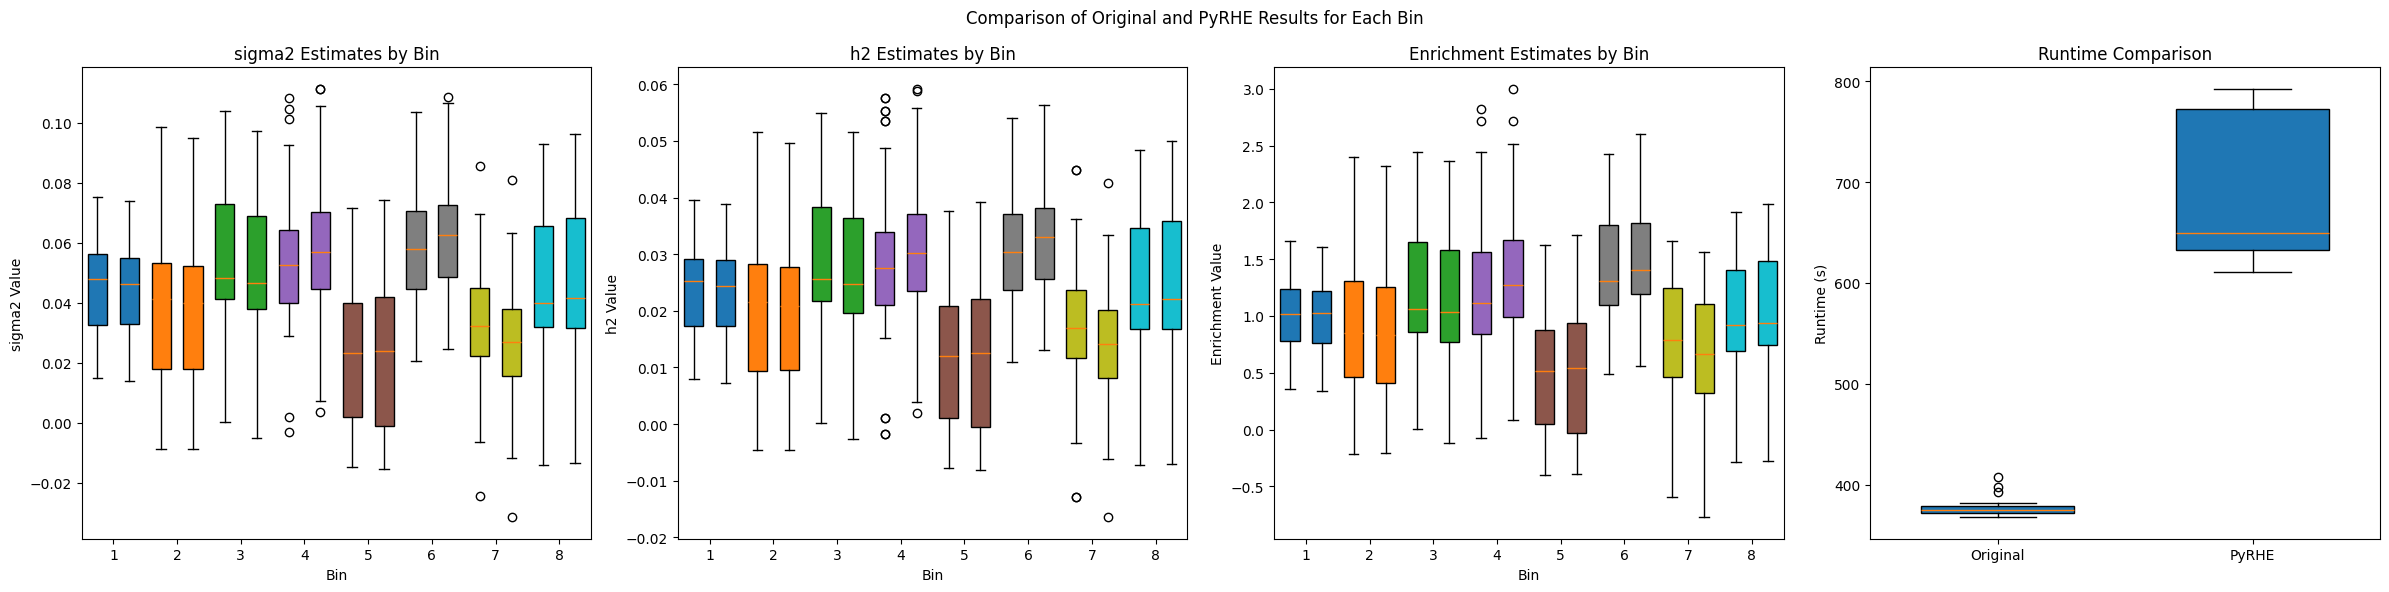

Metric     Bin  Original Mean   Original Std    PyRHE Mean      PyRHE Std      
sigma2     1    0.04511         0.01580         0.04438         0.01542        
h2         1    0.02372         0.00828         0.02334         0.00809        
Enrichment 1    1.01350         0.32503         1.00563         0.31859        
sigma2     2    0.03949         0.02806         0.03763         0.02810        
h2         2    0.02074         0.01468         0.01976         0.01471        
Enrichment 2    0.88286         0.63883         0.84962         0.64539        
sigma2     3    0.05158         0.02403         0.04857         0.02351        
h2         3    0.02716         0.01265         0.02557         0.01238        
Enrichment 3    1.16734         0.55057         1.11356         0.55205        
sigma2     4    0.05497         0.02754         0.05993         0.02711        
h2         4    0.02894         0.01455         0.03155         0.01433        
Enrichment 4    1.25580         0.69905 

In [42]:
summarize_results(True, 8, 25)


/tmp/ipykernel_24739/3236596506.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_bins)


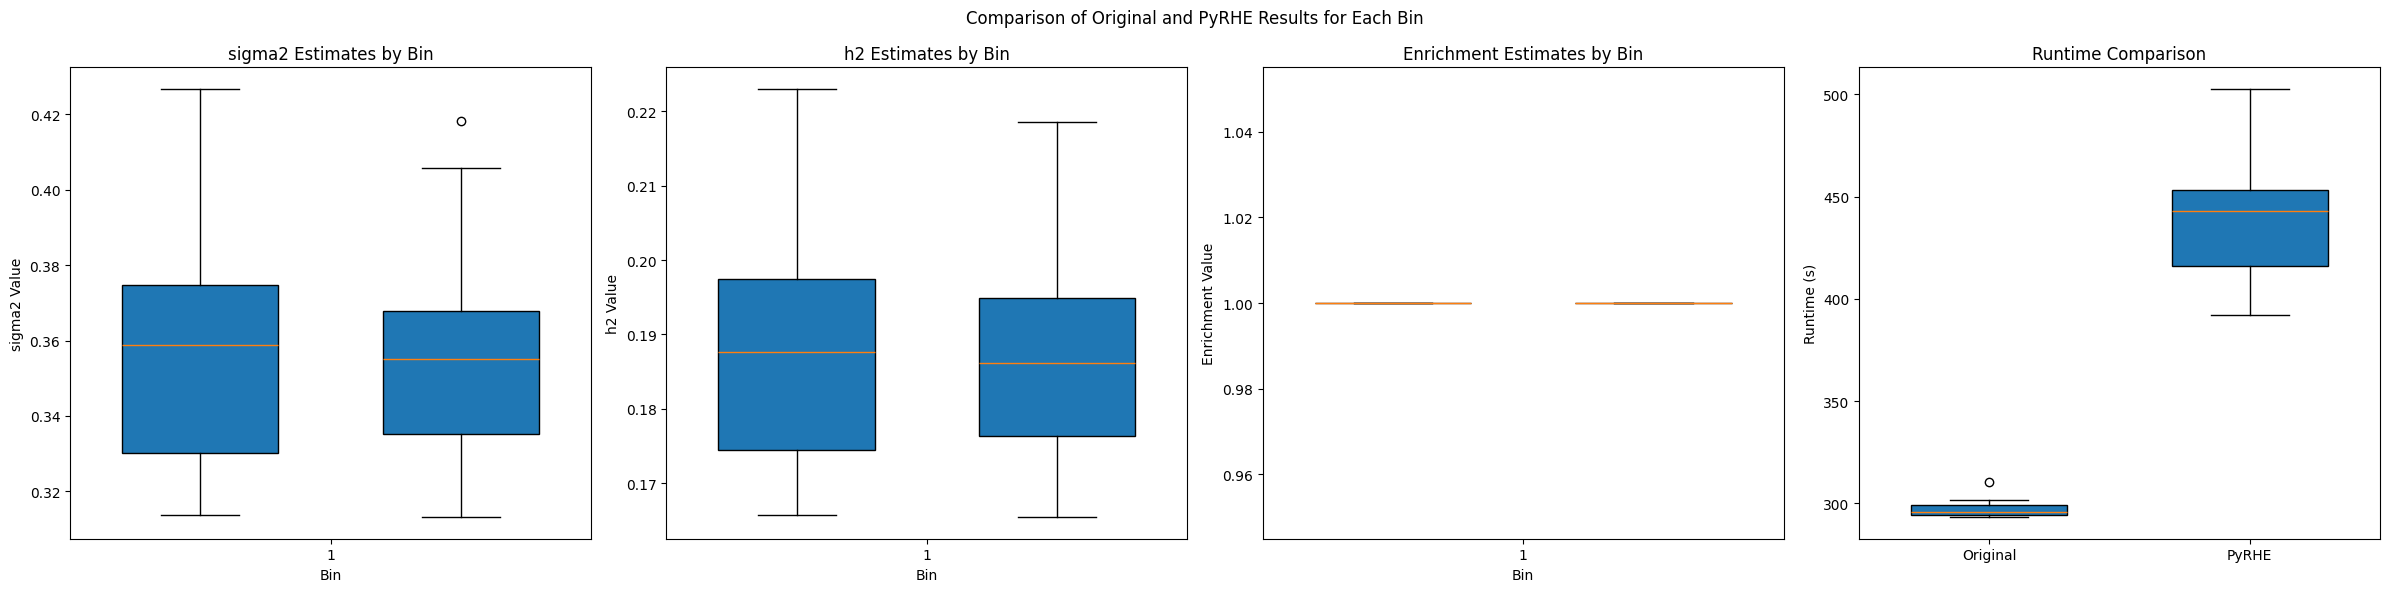

Metric     Bin  Original Mean   Original Std    PyRHE Mean      PyRHE Std      
sigma2     1    0.35659         0.02893         0.35448         0.02657        
h2         1    0.18797         0.01480         0.18686         0.01352        
Enrichment 1    1.00000         0.00000         1.00000         0.00000        


In [43]:
summarize_results(True, 1, 25)


/tmp/ipykernel_24739/3236596506.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_bins)


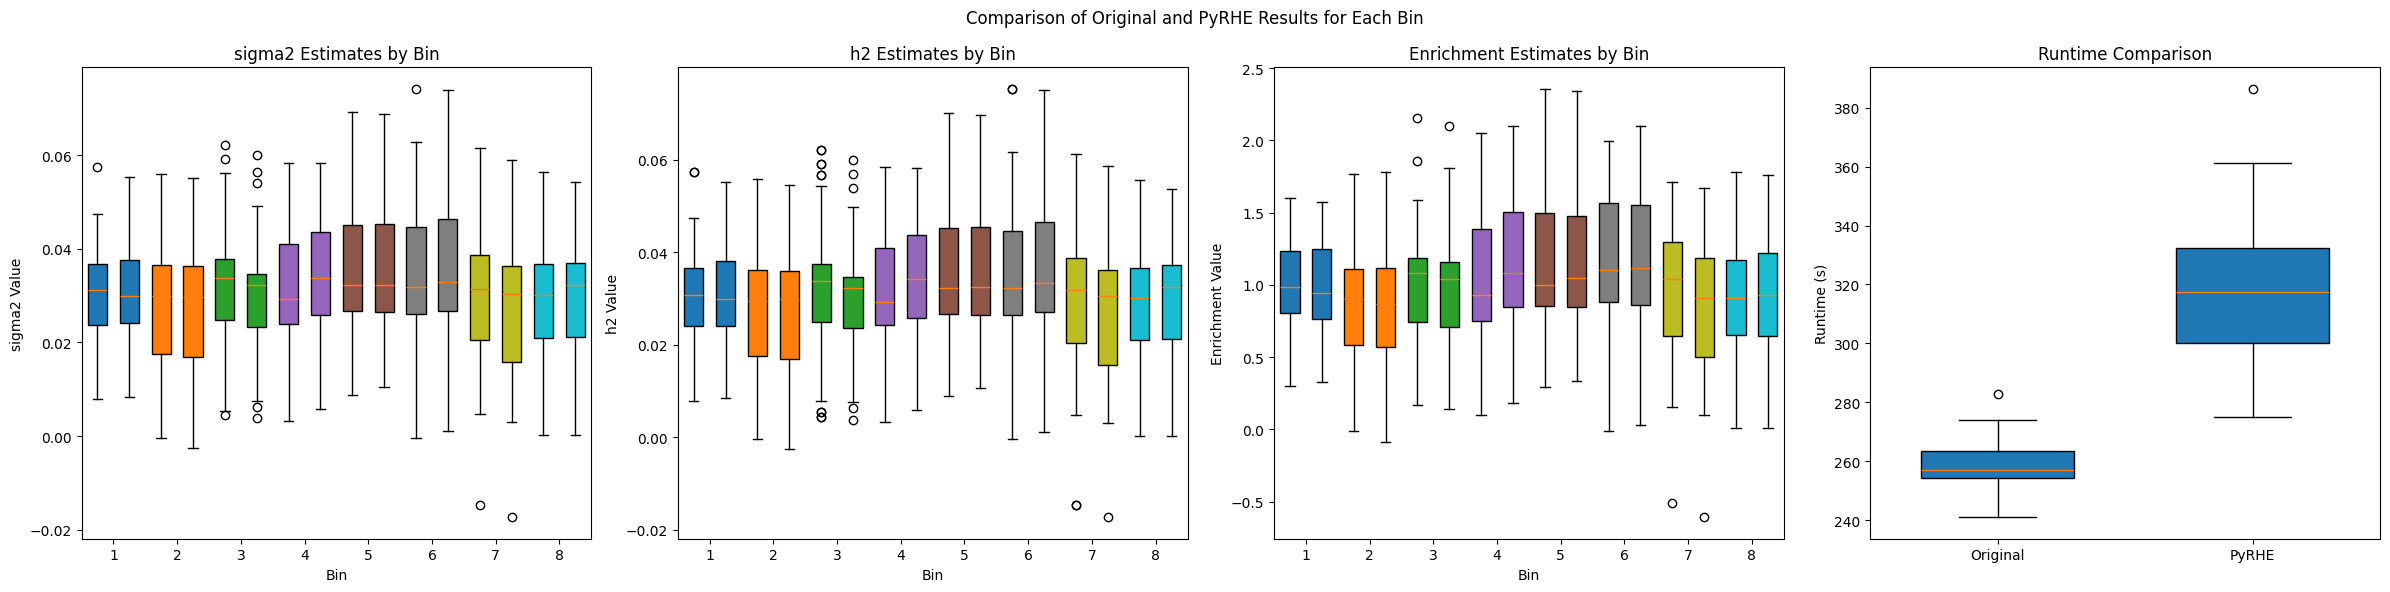

Metric     Bin  Original Mean   Original Std    PyRHE Mean      PyRHE Std      
sigma2     1    0.03176         0.01120         0.03139         0.01102        
h2         1    0.03178         0.01119         0.03142         0.01103        
Enrichment 1    1.01055         0.34162         1.00312         0.34070        
sigma2     2    0.02886         0.01488         0.02798         0.01491        
h2         2    0.02884         0.01482         0.02796         0.01486        
Enrichment 2    0.91586         0.47226         0.88801         0.46860        
sigma2     3    0.03196         0.01509         0.03068         0.01435        
h2         3    0.03199         0.01510         0.03071         0.01437        
Enrichment 3    1.00307         0.45818         0.97032         0.44484        
sigma2     4    0.03080         0.01271         0.03387         0.01257        
h2         4    0.03084         0.01275         0.03392         0.01261        
Enrichment 4    0.99922         0.44668 

In [44]:
summarize_results(False, 8, 25)


/tmp/ipykernel_24739/3236596506.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_bins)


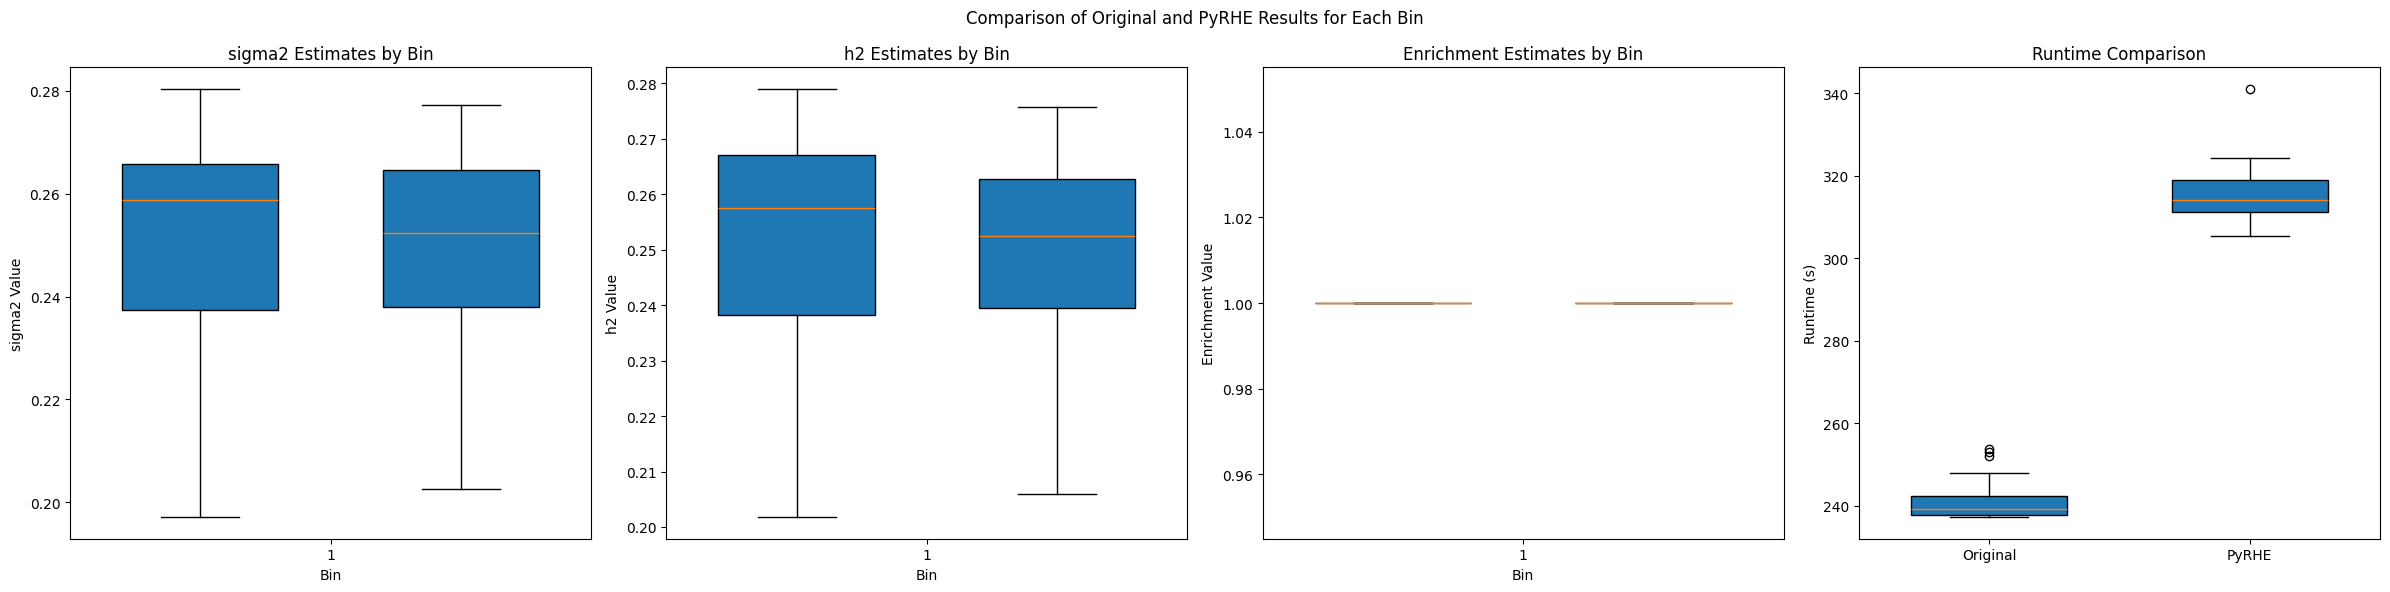

Metric     Bin  Original Mean   Original Std    PyRHE Mean      PyRHE Std      
sigma2     1    0.25120         0.02228         0.24859         0.02043        
h2         1    0.25227         0.02133         0.24966         0.01937        
Enrichment 1    1.00000         0.00000         1.00000         0.00000        


In [45]:
summarize_results(False, 1, 25)
